# Проект: классификация

In [1225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [1226]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None
(11162, 17)


In [1227]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [1228]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
col_nul_percent = df.isnull().mean()*100
col_with_nul = col_nul_percent[col_nul_percent>0].sort_values(ascending=False)
col_with_nul

balance    0.223974
dtype: float64

In [1229]:
df['balance'].isnull().sum()

np.int64(25)

### Задание 2

In [1230]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['poutcome'].value_counts()

poutcome
unknown    8326
failure    1228
success    1071
other       537
Name: count, dtype: int64

### Задание 3

In [1231]:
df['balance'] = (
    df['balance']
    .str.replace(r'\s*\$\s*', '', regex=True)  # Удаляем знак доллара и пробелы вокруг него
    .str.replace(r'\s+', '', regex=True)        # Удаляем все пробелы
    .str.replace(',', '.', regex=False)         # Заменяем запятую на точку
).astype(float)

In [1232]:
df['balance'].mean()

np.float64(1529.1290293615875)

### Задание 4

In [1233]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())

In [1234]:
df['balance'].mean()

np.float64(1526.9360329690019)

### Задание 5

In [1235]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mode_job=df['job'].mode().iloc[0]
mode_education=df['education'].mode().iloc[0]
df['job'] = df['job'].apply(lambda x: mode_job if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: mode_education if x=='unknown' else x)
df['education'].value_counts()

education
secondary    5973
tertiary     3689
primary      1500
Name: count, dtype: int64

In [1236]:
print(f' Самая популярная работа: {mode_job}')
print(f' Самое популярное образование: {mode_education}')

 Самая популярная работа: management
 Самое популярное образование: secondary


In [1237]:
df['balance'][(df['job'] == mode_job) & (df['education'] == mode_education)].mean()

np.float64(1598.8829787234042)

### Задание 6

In [1238]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    if isinstance(data, str):
        data = pd.read_csv(data)
    x = data[feature]
    # вычислить 25-ый и 75-ый квантили (первый и третий квартили) — Q25 и Q75 для признака, который мы исследуем
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    # вычислить межквартильное расстояние: IQR = Q75 — Q25
    iqr = quartile_3 - quartile_1
    # вычислить верхнюю и нижнюю границы Тьюки
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    # найти наблюдения, которые выходят за пределы границ
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [1239]:
quartile_1, quartile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
print(lower_bound)
print(upper_bound)
cleaned= df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
len(cleaned)

-2241.0
4063.0


10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [1240]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
cleaned['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='deposit'>

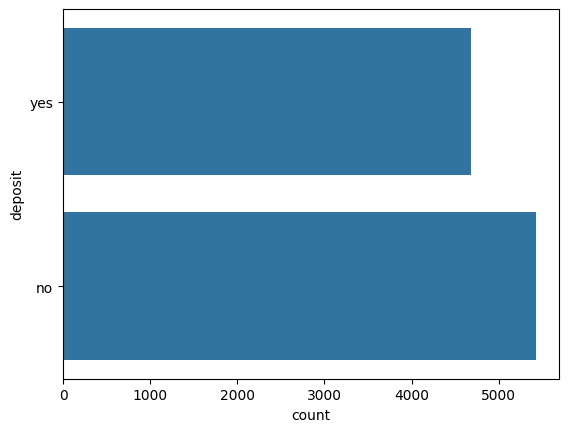

In [1241]:
sns.countplot(cleaned['deposit'])

### Задания 2 и 3

In [1242]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

# Каков максимальный возраст клиента банка?
cleaned['age'].max()




np.int64(95)

### Задания 4 и 5

In [1243]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


### Задание 6

In [1244]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
cleaned['poutcome'].value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

In [1245]:
print(f'В предыдущей success: {cleaned['deposit'][cleaned['poutcome'] == 'success'].value_counts()}')
print('='*30)
print(f'В предыдущей failure: {cleaned['deposit'][cleaned['poutcome'] == 'failure'].value_counts()}')
print('='*30)
print(f'В предыдущей unknown: {cleaned['deposit'][cleaned['poutcome'] == 'unknown'].value_counts()}')
print('='*30)
print(f'В предыдущей other: {cleaned['deposit'][cleaned['poutcome'] == 'other'].value_counts()}')


В предыдущей success: deposit
yes    861
no      84
Name: count, dtype: int64
В предыдущей failure: deposit
no     562
yes    547
Name: count, dtype: int64
В предыдущей unknown: deposit
no     4562
yes    3008
Name: count, dtype: int64
В предыдущей other: deposit
yes    265
no     216
Name: count, dtype: int64


### Задание 7

In [1246]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
dct = {}
for month in list(cleaned['month'].unique()):
    dct[month] = len(cleaned[(cleaned['month'] == month) & (cleaned['deposit'] == 'no')])
print(sorted(dct.items(), key=lambda item: item[1], reverse=True)[0][0])

may


### Задание 8

In [1247]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def age_group(age):
    if age <=30:
        return '<30'
    elif 30 < age <= 40:
        return '30-40'
    elif 40 < age <= 50:
        return '40-50'
    elif 50 < age <= 60:
        return '50-60'
    else:
        return '60+'
    
cleaned['age_group'] = cleaned['age'].apply(age_group)

In [1248]:
for age in list(cleaned['age_group'].unique()):
    print(f'В категории {age}: распределение следующее: {cleaned['deposit'][cleaned['age_group'] == age].value_counts()}')
    print('='*30)

В категории 50-60: распределение следующее: deposit
no     933
yes    692
Name: count, dtype: int64
В категории 40-50: распределение следующее: deposit
no     1360
yes     895
Name: count, dtype: int64
В категории 30-40: распределение следующее: deposit
no     2215
yes    1627
Name: count, dtype: int64
В категории <30: распределение следующее: deposit
yes    1051
no      819
Name: count, dtype: int64
В категории 60+: распределение следующее: deposit
yes    416
no      97
Name: count, dtype: int64


### Задания 9 и 10

In [1249]:
# В какой сфере занято наибольшее число клиентов банка?

cleaned['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

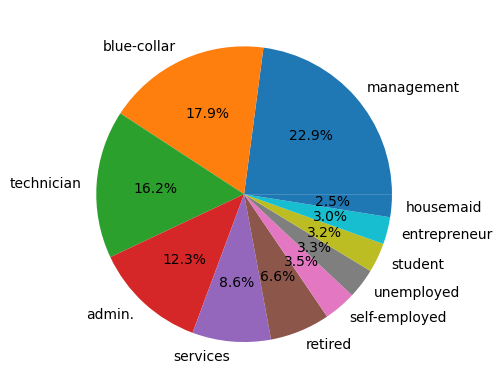

In [1250]:

plt.pie(cleaned['job'].value_counts(), labels=cleaned['job'].value_counts().index,  autopct='%1.1f%%')
plt.show

In [1251]:
sorted(cleaned['deposit'][cleaned['marital'] == 'single'].value_counts().index)

['no', 'yes']

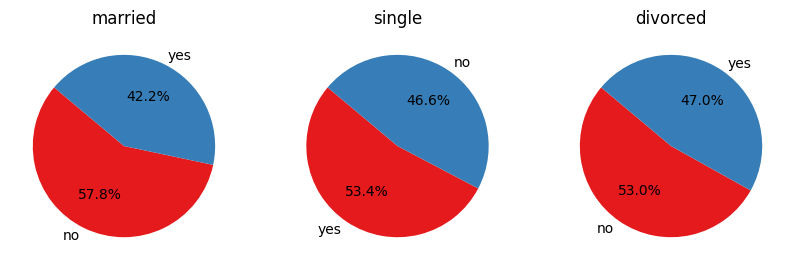

In [1252]:
lst_marital=list(cleaned['marital'].unique())
plt.figure(figsize=(10,10))
for i in lst_marital:
    plt.subplot(1, 3, lst_marital.index(i)+1)
    plt.title(i)
    plt.pie(cleaned['deposit'][cleaned['marital'] == i].value_counts(), 
            colors=plt.cm.Set1(range(cleaned['deposit'][cleaned['marital'] == i].nunique())), 
            autopct='%1.1f%%', startangle=140, 
            labels=cleaned['deposit'][cleaned['marital'] == i].value_counts().index)
    

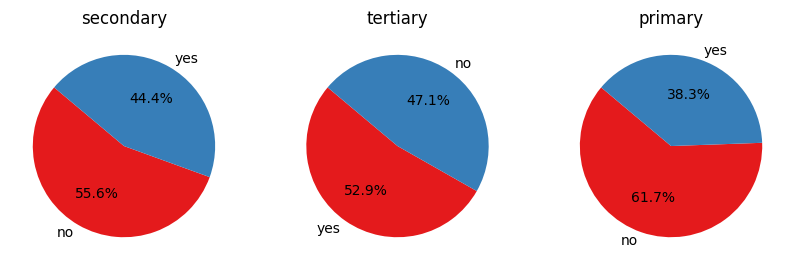

In [1253]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
lst_education=list(cleaned['education'].unique())
plt.figure(figsize=(10,10))
for i in lst_education:
    plt.subplot(1, 3, lst_education.index(i)+1)
    plt.title(i)
    plt.pie(cleaned['deposit'][cleaned['education'] == i].value_counts(), 
            colors=plt.cm.Set1(range(cleaned['deposit'][cleaned['education'] == i].nunique())), 
            autopct='%1.1f%%', startangle=140, 
            labels=cleaned['deposit'][cleaned['education'] == i].value_counts().index)

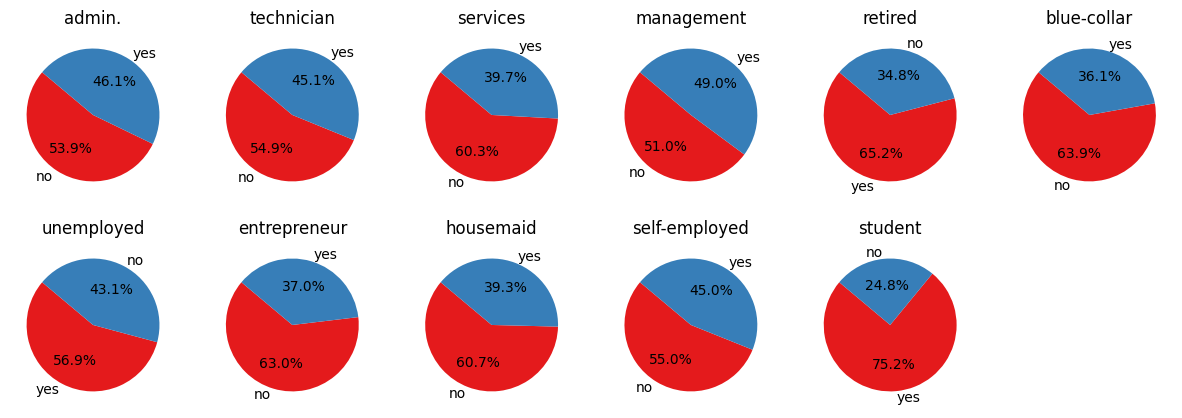

In [1254]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
lst_job=list(cleaned['job'].unique())
plt.figure(figsize=(15,5))
for i in lst_job:
    plt.subplot(2, 6, lst_job.index(i)+1)
    plt.title(i)
    plt.pie(cleaned['deposit'][cleaned['job'] == i].value_counts(), 
            colors=plt.cm.Set1(range(cleaned['deposit'][cleaned['job'] == i].nunique())), 
            autopct='%1.1f%%', startangle=140, 
            labels=cleaned['deposit'][cleaned['job'] == i].value_counts().index)

### Задание 11

In [1255]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_yes = cleaned[cleaned['deposit'] == 'yes']
df_no = cleaned[cleaned['deposit'] == 'no']

In [1256]:
pivot_yes = df_yes.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)
pivot_no = df_no.pivot_table(index='education', columns='marital', aggfunc='size', fill_value=0)

Text(627.9949494949494, 0.5, 'Уровень образования')

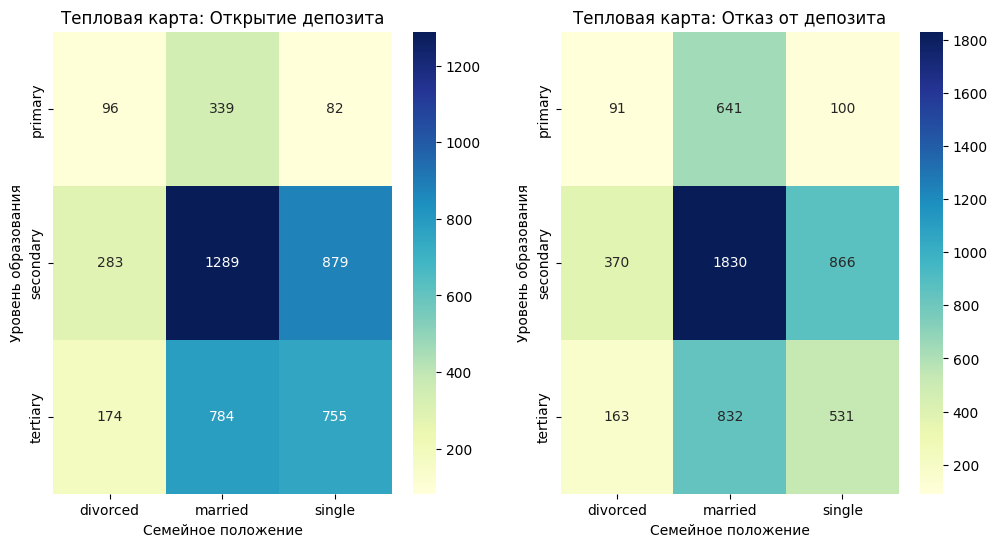

In [1257]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(pivot_yes, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Тепловая карта: Открытие депозита')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

plt.subplot(1, 2, 2)
sns.heatmap(pivot_no, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Тепловая карта: Отказ от депозита')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

## Часть 3: преобразование данных

### Задание 1

In [1258]:
# преобразуйте уровни образования

label_encoder = LabelEncoder()
cleaned['education'] = label_encoder.fit_transform(cleaned['education'])

In [1259]:
cleaned['education'].sum()

np.int64(11995)

### Задания 2 и 3

In [1260]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['deposit'] = label_encoder.fit_transform(cleaned['deposit'])
cleaned['age_group'] = label_encoder.fit_transform(cleaned['age_group'])
cleaned['default'] = label_encoder.fit_transform(cleaned['default'])
cleaned['housing'] = label_encoder.fit_transform(cleaned['housing'])
cleaned['loan'] = label_encoder.fit_transform(cleaned['loan'])

In [1261]:
cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()

np.float64(0.6354280059376547)

In [1262]:
cleaned['deposit'].std()

np.float64(0.4986712532452124)

In [1263]:
cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,0
11158,39,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,0
11159,32,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,0
11160,43,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,1


### Задание 4

In [1264]:
# создайте дамми-переменные
cleaned_dummies = pd.get_dummies(cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

### Задания 5 и 6

<function matplotlib.pyplot.show(close=None, block=None)>

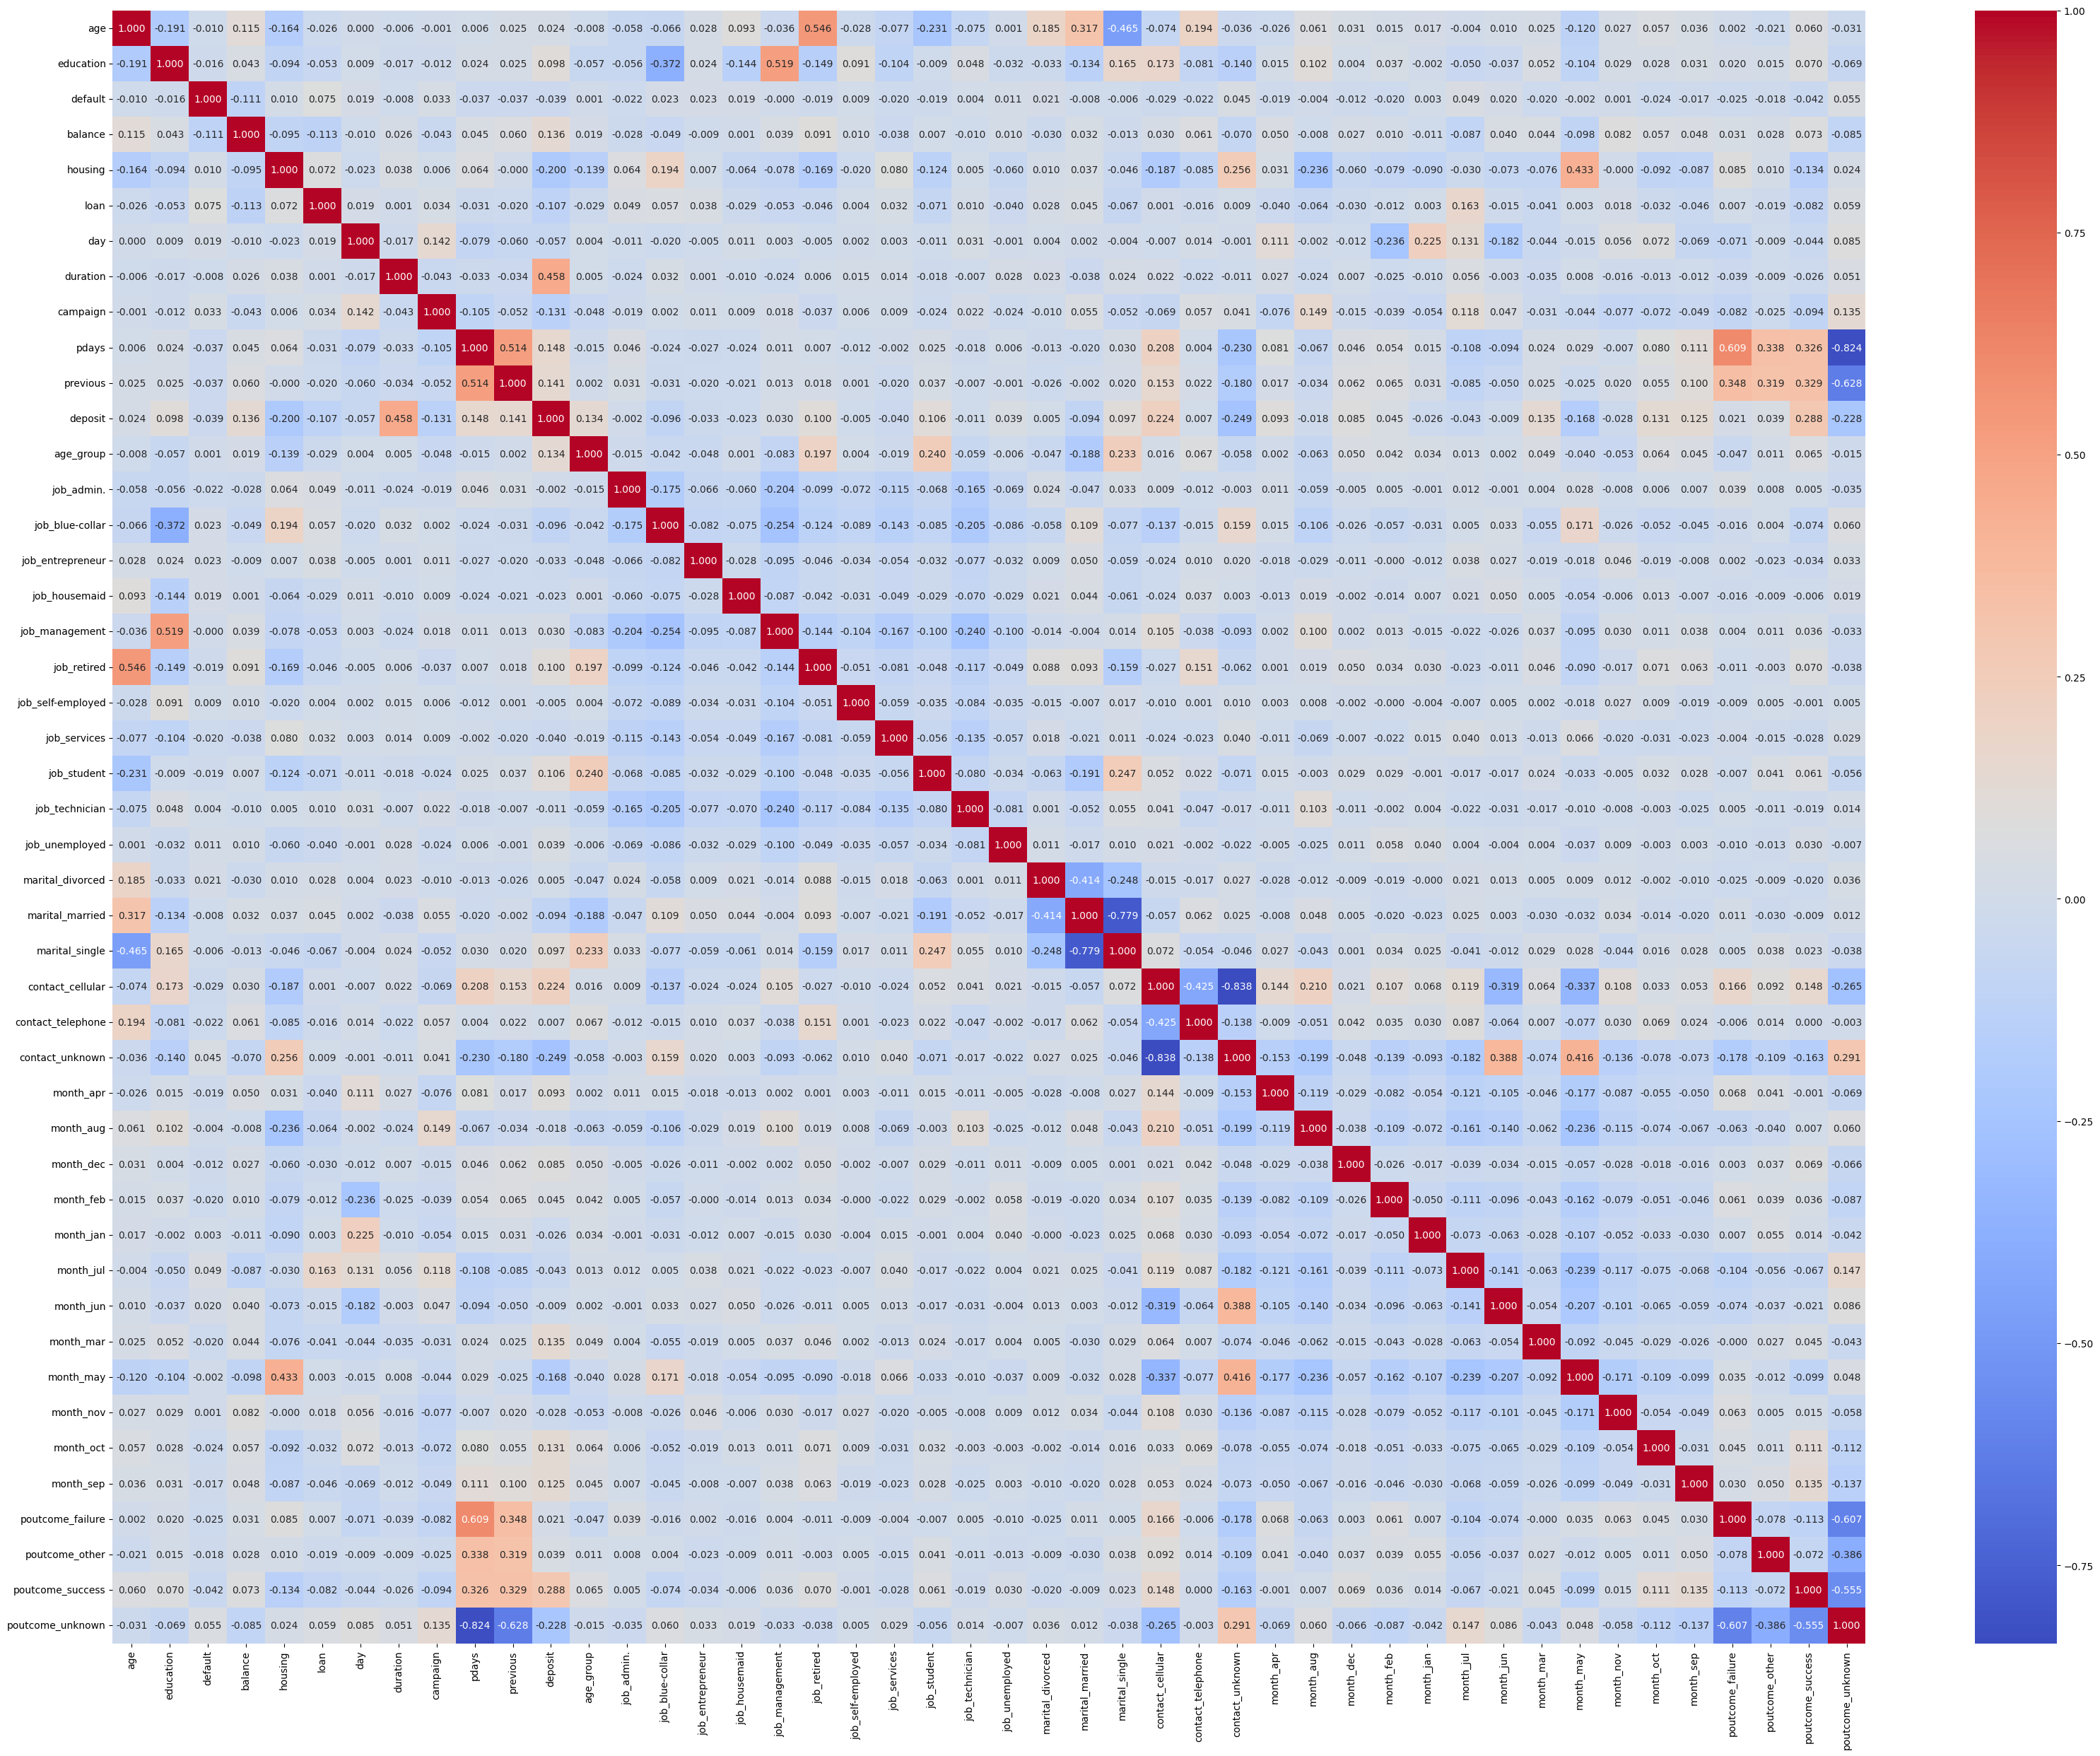

In [1265]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
matrix = cleaned_dummies.corr()
plt.figure(figsize=(40, 30))
sns.heatmap(data=matrix, annot=True,  cmap='coolwarm', fmt='.3f')
plt.show

In [1266]:
sorted_corr =matrix.unstack().sort_values(ascending=False)
sorted_corr = sorted_corr[sorted_corr < 1]
sorted_corr

poutcome_failure  pdays               0.608719
pdays             poutcome_failure    0.608719
job_retired       age                 0.545524
age               job_retired         0.545524
job_management    education           0.518735
                                        ...   
marital_single    marital_married    -0.779038
pdays             poutcome_unknown   -0.824031
poutcome_unknown  pdays              -0.824031
contact_unknown   contact_cellular   -0.837885
contact_cellular  contact_unknown    -0.837885
Length: 2070, dtype: float64

### Задания 7 и 8

In [1267]:
X = cleaned_dummies.drop(['deposit'], axis=1)
y = cleaned_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [1268]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [1269]:
y_test.mean()

np.float64(0.46326836581709147)

### Задание 9

In [1270]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func=f_classif, k=15)
X_new = selector.fit_transform(X_train, y_train)
selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]
features=list(selected_features)
features

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [1271]:
X_train = X_train[features]
X_test = X_test[features]

### Задание 10

In [1272]:
# нормализуйте данные с помощью minmaxsxaler

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mean_first_predictor = X_test_scaled[:, 0].mean()
mean_first_predictor

np.float64(0.46823674223097866)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag')
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
print(metrics.accuracy_score(y_test, y_pred))

0.8083958020989506


### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    )
dt_clf.fit(X_train_scaled, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [1286]:
y_pred_dt_test = dt_clf.predict(X_test_scaled)
y_pred_dt_train = dt_clf.predict(X_train_scaled)
print(metrics.classification_report(y_test, y_pred_dt_test))
print(metrics.classification_report(y_train, y_pred_dt_train))


              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



In [1291]:
train_accuracies = []
test_accuracies = []
max_depths = range(1,21)
for max_depth in max_depths:
    dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=max_depth
    )
    dt_clf.fit(X_train_scaled, y_train)
    y_pred_dt_test = dt_clf.predict(X_test_scaled)
    y_pred_dt_train = dt_clf.predict(X_train_scaled)
    train_accuracies.append(metrics.accuracy_score(y_train, y_pred_dt_train))
    test_accuracies.append(metrics.accuracy_score(y_test, y_pred_dt_test))
    
print(max(test_accuracies))
print(max_depths[test_accuracies.index(max(test_accuracies))])

0.8149925037481259
7


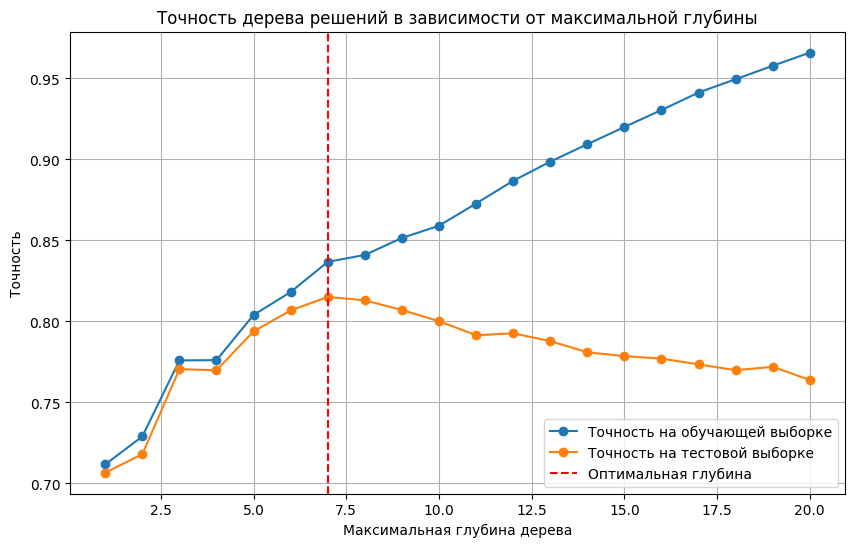

In [1294]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Точность на обучающей выборке', marker='o')
plt.plot(max_depths, test_accuracies, label='Точность на тестовой выборке', marker='o')
plt.axvline(max_depths[test_accuracies.index(max(test_accuracies))], color='r', linestyle='--', label='Оптимальная глубина')
plt.title('Точность дерева решений в зависимости от максимальной глубины')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()

### Задание 5

In [1300]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
model = tree.DecisionTreeClassifier(random_state=42)
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая F1-мера на обучающей выборке: {best_f1_score}")
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_scaled)
test_f1_score = metrics.f1_score(y_test, y_test_pred)
print(f"F1-мера на тестовой выборке: {test_f1_score}")

Лучшие параметры: {'max_depth': 7, 'min_samples_split': 2}
Лучшая F1-мера на обучающей выборке: 0.8133682406346855
F1-мера на тестовой выборке: 0.800763844684914


In [1299]:
model_best = tree.DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_split=2)
model_best.fit(X_train_scaled, y_train)
y_pred_test_dt_best = model_best.predict(X_test_scaled)
print(metrics.f1_score(y_test, y_pred_test_dt_best))

0.800763844684914


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [1301]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

rf_clf.fit(X_train_scaled, y_train)

y_pred_test = rf_clf.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [1304]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_test_pred_gb = gb_model.predict(X_test_scaled)
test_f1_score_gb = metrics.f1_score(y_test, y_test_pred_gb, average='macro')
print(f"F1-мера на тестовой выборке (градиентный бустинг): {test_f1_score_gb}")
print(metrics.classification_report(y_test, y_test_pred_gb))

F1-мера на тестовой выборке (градиентный бустинг): 0.8258450927605894
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Определение базовых моделей
from sklearn.ensemble import StackingClassifier

base_models = [
    ('decision_tree', tree.DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_split=2)),
    ('gradient_boosting', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))
]

# Определение метамодели
meta_model = linear_model.LogisticRegression()

# Создание стекинг-классификатора
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Обучение модели стекинга
stacking_model.fit(X_train_scaled, y_train)

# Оценка производительности модели стекинга на тестовой выборке
y_test_pred_stacking = stacking_model.predict(X_test_scaled)
test_f1_score_stacking = metrics.f1_score(y_test, y_test_pred_stacking, average='weighted')

print(f"F1-мера на тестовой выборке (стекинг): {test_f1_score_stacking}")
print(metrics.classification_report(y_test, y_test_pred_stacking))

F1-мера на тестовой выборке (стекинг): 0.8250802701493263
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

In [1308]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

# Получение важности признаков
feature_importances = gb_model.feature_importances_

# Создание DataFrame для удобного отображения важности признаков
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Сортировка по важности и выбор трех наиболее значимых признаков
top_features = importance_df.sort_values(by='Importance', ascending=False).head(3)

print("Три наиболее значимые признака:")
print(top_features)

Три наиболее значимые признака:
             Feature  Importance
2           duration    0.507106
13  poutcome_success    0.114958
8    contact_unknown    0.072622


### Задания 6,7,8

In [1315]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

# Определение функции для оптимизации гиперпараметров
def objective(trial):
    # Определение гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создание и обучение модели случайного леса
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Предсказание на тестовой выборке и оценка точности
    y_pred = model.predict(X_test_scaled)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    return accuracy

# Запуск оптимизации с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вычисляем финальные метрики
acc_optuna = metrics.accuracy_score(y_test, y_pred)
f1_optuna = metrics.f1_score(y_test, y_pred, average='weighted')

# Вывод лучших параметров и их оценки
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

print("Final Accuracy on test set: ", metrics.accuracy_score(y_test, y_pred))
print("Final F1 Score on test set: ", metrics.f1_score(y_test, y_pred, average='weighted'))


[I 2025-04-06 15:57:07,163] A new study created in memory with name: no-name-ef1a7d1d-88a4-4189-aaf0-fc61e29c50de
[I 2025-04-06 15:57:08,137] Trial 0 finished with value: 0.8272863568215892 and parameters: {'n_estimators': 143, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8272863568215892.
[I 2025-04-06 15:57:08,814] Trial 1 finished with value: 0.8269865067466267 and parameters: {'n_estimators': 103, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8272863568215892.
[I 2025-04-06 15:57:09,481] Trial 2 finished with value: 0.823688155922039 and parameters: {'n_estimators': 118, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8272863568215892.
[I 2025-04-06 15:57:10,181] Trial 3 finished with value: 0.8263868065967016 and parameters: {'n_estimators': 129, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8272863568215892.
[I 2025-04-06 15:57:10,864] Trial 4 finished with value: 0.8266866566716642

Best hyperparameters:  {'n_estimators': 172, 'max_depth': 22, 'min_samples_leaf': 3}
Best accuracy:  0.8320839580209896
Final Accuracy on test set:  0.8083958020989506
Final F1 Score on test set:  0.8071301556315953
